from google.colab import drive
drive.mount("/content/drive")


%cd /content/drive/MyDrive

!pwd

!nvidia-smi

!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113


!pip install transformers[sentencepiece]

import torch
print(torch.cuda.is_available())

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")


# %cd /content/drive/MyDrive

# !pwd

# !nvidia-smi

# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113


# !pip install transformers[sentencepiece]

# import torch
# print(torch.cuda.is_available())

In [2]:
!nvidia-smi

Thu Mar  2 10:53:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.30       Driver Version: 522.30       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 55%   55C    P8    36W / 350W |   2423MiB / 24576MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Pytorch tutorial

## 1.1 quickstart

### 1.1.1 Working with data

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

C:\Users\shaohan.tian\scoop\apps\miniconda3\current\envs\automl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
batch_size = 1024

# Create data loaders.
train_dataloader = DataLoader(training_data, num_workers=2, batch_size=batch_size)
test_dataloader = DataLoader(test_data, num_workers=2, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1024, 1, 28, 28])
Shape of y: torch.Size([1024]) torch.int64


### 1.1.3 Creating model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 4096),
            nn.ReLU(),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 1.1.3 Optimizing the Model Parameters

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print(size)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
60000
loss: 2.221145  [    0/60000]
Test Error: 
 Accuracy: 60.6%, Avg loss: 2.207505 

Epoch 2
-------------------------------
60000
loss: 2.211988  [    0/60000]
Test Error: 
 Accuracy: 62.8%, Avg loss: 2.197810 

Epoch 3
-------------------------------
60000
loss: 2.202583  [    0/60000]
Test Error: 
 Accuracy: 64.9%, Avg loss: 2.187841 

Epoch 4
-------------------------------
60000
loss: 2.192909  [    0/60000]
Test Error: 
 Accuracy: 66.5%, Avg loss: 2.177582 

Epoch 5
-------------------------------
60000
loss: 2.182956  [    0/60000]
Test Error: 
 Accuracy: 67.7%, Avg loss: 2.167014 

Epoch 6
-------------------------------
60000
loss: 2.172707  [    0/60000]
Test Error: 
 Accuracy: 68.8%, Avg loss: 2.156128 

Epoch 7
-------------------------------
60000
loss: 2.162146  [    0/60000]
Test Error: 
 Accuracy: 69.6%, Avg loss: 2.144906 

Epoch 8
-------------------------------
60000
loss: 2.151258  [    0/60000]
Test Error: 
 Accuracy: 70.3

### 1.1.3 Save models

In [19]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### 1.1.3 Loading models

In [14]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Sneaker", Actual: "Sneaker"


## 1.2 Tensors

In [16]:
import torch
import numpy as np

### 1.2.1 Initializing a tensor

In [17]:
# from data
data = [[1,2], [3, 4]]
x_data = torch.tensor(data)
print(x_data)

tensor([[1, 2],
        [3, 4]])


In [18]:
# from np
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

tensor([[1, 2],
        [3, 4]])


In [19]:
# from another tensor
x_ones = torch.ones_like(x_data)
print(f"Ones tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f"Random tensor: \n {x_rand} \n")

Ones tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random tensor: 
 tensor([[0.5708, 0.9996],
        [0.7449, 0.9894]]) 



In [20]:
# with random or constant values
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.6359, 0.9754, 0.6903],
        [0.1986, 0.6001, 0.2841]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### 1.2.2 Attributes of tensor

In [21]:
tensor = torch.rand(3, 4)

print(tensor.shape)
print(tensor.dtype)
print(tensor.device)

torch.Size([3, 4])
torch.float32
cpu


### 1.2.3 Operations of tensors

In [22]:
# using GPU with higher speed than CPU
if torch.cuda.is_available():
    tensor.to("cuda")
print(tensor.device)

cpu


In [23]:
# Standard numpy-like indexing and slicing:
tensor = torch.ones(4,4)

print(f"first row: {tensor[0]}")
print(f"first column: {tensor[:, 0]}")
print(f"last column: {tensor[:, -1]}")
tensor[:, 1] = 0
print(tensor)

first row: tensor([1., 1., 1., 1.])
first column: tensor([1., 1., 1., 1.])
last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [24]:
# Joining tensors
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

t1 = torch.cat([tensor, tensor, tensor], dim=0)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [25]:
# Arithmetic operations

# compute martrix multiplication
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)
print(y3) 

# computes element-wise product
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)
print(z3) 

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [26]:
# convert to python numerical value
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [27]:
# In-place operations
print(f"{tensor} \n")
tensor.add_(5)
print(f"{tensor} \n")

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]]) 



### 1.2.4 Bridge with numpy
Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

In [28]:
# tensor to np
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [29]:
# np to tensor
n = np.ones(5)
t = torch.from_numpy(n)

np.add(n, 1, out=n)
print(f"n: {n} \n")
print(f"t: {t} \n")

n: [2. 2. 2. 2. 2.] 

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64) 



## 1.3 Autograd

### 1.3.1 Simple example

In [30]:
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

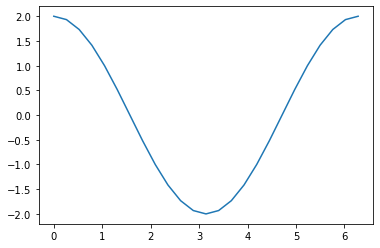

In [31]:
x = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
y = torch.sin(x) * 2 + 1
out = y.sum()

out.backward()
plt.plot(x.detach(), x.grad.detach())

### 1.3.2 Autograd in Training


In [32]:
batch_size = 10
dim_in = 1000
hidden_size = 100
dim_out = 10

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# torch.nn.Module assumed that we want to track gradients on the layers’ weights for learning
some_input = torch.randn(batch_size, dim_in, requires_grad=False)
ideal_output = torch.randn(batch_size, dim_out, requires_grad=False)

model = TinyModel()

In [33]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([-0.0613,  0.0107,  0.0208,  0.0916, -0.0508, -0.0497,  0.0597,  0.0893,
         0.0790, -0.0682], grad_fn=<SliceBackward0>)
None


In [34]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(88.9037, grad_fn=<SumBackward0>)


In [35]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0613,  0.0107,  0.0208,  0.0916, -0.0508, -0.0497,  0.0597,  0.0893,
         0.0790, -0.0682], grad_fn=<SliceBackward0>)
tensor([-0.2509, -0.9290,  1.3722,  0.8267,  0.1147,  1.1165, -4.4951,  0.1854,
         1.0820, -1.2363])


In [36]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0611,  0.0117,  0.0194,  0.0908, -0.0509, -0.0508,  0.0642,  0.0891,
         0.0780, -0.0670], grad_fn=<SliceBackward0>)
tensor([-0.2509, -0.9290,  1.3722,  0.8267,  0.1147,  1.1165, -4.4951,  0.1854,
         1.0820, -1.2363])


In [37]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()

print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad()

print(model.layer2.weight.grad[0][0:10])

tensor([-0.2509, -0.9290,  1.3722,  0.8267,  0.1147,  1.1165, -4.4951,  0.1854,
         1.0820, -1.2363])
tensor([  7.1715,  -0.5785,   9.0167,  -4.9770,   7.7357,   5.0738, -20.9482,
          0.9372,  -0.9210,  -4.9195])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### 1.3.3 Turning Autograd Off and On


In [38]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


In [39]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3
c1 = a * b
print(c1)

# not change data original grad
with torch.no_grad():
    c2 = a + b
    print(c2)

c3 = a * b
print(c3)

tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


In [40]:
def add_ten1(x, y):
    return x+y

@torch.no_grad()
def add_ten2(x, y):
    return x+y

a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_ten1(a, b)
print(c1)

c2 = add_ten2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


In [41]:
x = torch.rand(2, 3, requires_grad=True )
y = x.detach()

print(x)
print(y)

tensor([[0.2878, 0.3160, 0.3005],
        [0.7818, 0.4741, 0.3922]], requires_grad=True)
tensor([[0.2878, 0.3160, 0.3005],
        [0.7818, 0.4741, 0.3922]])


### 1.3.4 Autograd and In-place Operations

In [42]:
# The following code cell throws a runtime error. This is expected.
# a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
# torch.sin_(a)

### 1.3.5 Autograd Profiler


In [43]:
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True

x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y

print(prf.key_averages().table(sort_by='self_cpu_time_total'))

-------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::mul        50.23%       5.585ms        50.23%       5.585ms       5.585us          1000  
    aten::div        49.77%       5.534ms        49.77%       5.534ms       5.534us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 11.119ms



In [44]:
x = torch.randn(3, requires_grad=True)

y = x * 2
print(y.data.norm)

<bound method Tensor.norm of tensor([-2.6017,  2.2762, -1.8331])>


### 1.3.6 The High-Level API
*italicized text*

In [45]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.5238]), tensor([0.2933]))


(tensor([[3.3769]]), tensor([[3.]]))

## 1.4 Building Models

In [46]:
import torch

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()
    
    def forward(self):
        x = self.linear1(x)
        x = self.activateion(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param.shape)
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
torch.Size([200, 100])
Parameter containing:
tensor([[-0.0712, -0.0674, -0.0792,  ...,  0.0696, -0.0817, -0.0195],
        [ 0.0605, -0.0435, -0.0680,  ..., -0.0935, -0.0624,  0.0639],
        [-0.0099,  0.0394, -0.0961,  ...,  0.0979, -0.0497, -0.0918],
        ...,
        [-0.0870,  0.0715, -0.0371,  ...,  0.0805,  0.0854, -0.0340],
        [ 0.0949,  0.0506, -0.0968,  ...,  0.0184, -0.0472, -0.0151],
        [ 0.0543,  0.0377,  0.0590,  ..., -0.0496,  0.0553,  0.0182]],
       requires_grad=True)
torch.Size([200])
Parameter containing:
tensor([ 0.0010,  0.0930,  0.0387,  0.0659,  0.0906,  0.0438, -0.0374,  0.0487,
         0.0101, -0.0673, -0.0905,  0.0763,  0.0078, -0.0560, -0.0479, -0.0992,

### 1.4.1 Linear layers

In [47]:
from torch import nn

lin = nn.Linear(3, 2)
x = torch.rand(1, 3)
print(f"Input: {x}")

print('\n\nWeight and Bias parameters:')
for param in lin.parameters():
    print(param)
    print(param.shape)

y = lin(x)
print('\n\nOutput:')
print(y)

Input: tensor([[0.8423, 0.9456, 0.4102]])


Weight and Bias parameters:
Parameter containing:
tensor([[-0.3958,  0.3775,  0.2210],
        [ 0.1991, -0.3296,  0.3816]], requires_grad=True)
torch.Size([2, 3])
Parameter containing:
tensor([0.2895, 0.3240], requires_grad=True)
torch.Size([2])


Output:
tensor([[0.4037, 0.3365]], grad_fn=<AddmmBackward0>)


In [48]:
lin.weight

Parameter containing:
tensor([[-0.3958,  0.3775,  0.2210],
        [ 0.1991, -0.3296,  0.3816]], requires_grad=True)

In [49]:
lin.bias

Parameter containing:
tensor([0.2895, 0.3240], requires_grad=True)

### 1.4.2 Convolutional Layers


In [50]:
import torch.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### 1.4.3 Recurrent Layers


In [51]:
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

### 1.4.4 Transformers

For details, check out the documentation on transformer classes, and the relevant tutorial on pytorch.org.*italicized text*

### 1.4.5 Data Manipulation Layers


In [52]:
# Max pooling
my_tensor = torch.rand(1, 6, 6)
print(my_tensor)

maxpool_layer = torch.nn.MaxPool2d(3)
print(maxpool_layer(my_tensor))

tensor([[[0.6296, 0.8568, 0.4704, 0.0603, 0.9101, 0.5366],
         [0.7589, 0.9036, 0.0076, 0.5231, 0.1793, 0.8988],
         [0.0136, 0.1350, 0.1787, 0.2761, 0.0959, 0.6726],
         [0.9542, 0.9667, 0.1093, 0.2836, 0.8138, 0.3823],
         [0.1005, 0.3841, 0.4166, 0.3017, 0.3889, 0.6314],
         [0.6077, 0.5204, 0.4107, 0.6575, 0.1223, 0.0604]]])
tensor([[[0.9036, 0.9101],
         [0.9667, 0.8138]]])


In [53]:
# Normalization layers
my_tensor = torch.rand(1, 4, 5) * 20 + 5
print(my_tensor)

print(my_tensor.mean())

norm_layer = torch.nn.BatchNorm1d(4)
normed_tensor = norm_layer(my_tensor)
print(normed_tensor)

print(normed_tensor.mean())

tensor([[[11.8037, 11.2297, 13.3219, 13.3868, 11.5550],
         [ 9.0366,  6.3913, 13.0140, 19.0773, 24.5103],
         [14.8226, 16.8181, 15.6249, 20.9170, 15.1970],
         [23.7003, 24.3243, 22.9196, 14.3701, 16.3181]]])
tensor(15.9169)
tensor([[[-0.4993, -1.1284,  1.1642,  1.2354, -0.7719],
         [-0.8114, -1.2112, -0.2104,  0.7060,  1.5270],
         [-0.8333,  0.0639, -0.4725,  1.9069, -0.6649],
         [ 0.8152,  0.9660,  0.6266, -1.4393, -0.9686]]],
       grad_fn=<NativeBatchNormBackward0>)
tensor(-5.0664e-08, grad_fn=<MeanBackward0>)


In [54]:
# Dropout layers
my_tensor = torch.rand(1, 4, 4)
 
dropout = torch.nn.Dropout(p=0.2)
print(my_tensor)
print(my_tensor)

tensor([[[0.8308, 0.2151, 0.2839, 0.9724],
         [0.7657, 0.7756, 0.0546, 0.7875],
         [0.9488, 0.4554, 0.0147, 0.4247],
         [0.0104, 0.4450, 0.1324, 0.7242]]])
tensor([[[0.8308, 0.2151, 0.2839, 0.9724],
         [0.7657, 0.7756, 0.0546, 0.7875],
         [0.9488, 0.4554, 0.0147, 0.4247],
         [0.0104, 0.4450, 0.1324, 0.7242]]])


### 1.4.6 Activation Functions

more details related to [Non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

### 1.4.6 Loss Function

more details related to [nn.loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

## 1.5 TensorBoard Support

In [2]:
# pytoch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# image dispaly
import matplotlib.pyplot as plt
import numpy as np

# pytorch tensorboard support
from torch.utils.tensorboard import SummaryWriter

C:\Users\shaohan.tian\scoop\apps\miniconda3\current\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.5.1 Showing images in TensorBoard

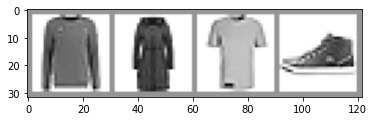

In [3]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=1)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=1)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [4]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

### 1.5.2 Graphing Scalars to Visualize Training

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


### 1.5.3 Visualizing Your Model

In [10]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

# tensorboard --logdir runs

### 1.5.4 Visualizing Your Dataset with Embeddings

In [9]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

## 1.6 Training Models

### 1.6.1 Dataset and DataLoader


In [55]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Pullover  Sandal  Sneaker  Pullover


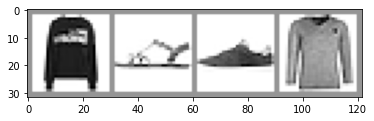

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

### 1.6.2 The Model

In [57]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

### 1.6.3 Loss Function

In [58]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.2580, 0.4049, 0.4311, 0.8955, 0.1907, 0.1284, 0.5568, 0.8959, 0.7798,
         0.9368],
        [0.6305, 0.8609, 0.6708, 0.7826, 0.7237, 0.6664, 0.4686, 0.0549, 0.9245,
         0.0547],
        [0.0217, 0.2005, 0.8338, 0.9548, 0.5958, 0.5581, 0.9758, 0.0170, 0.0927,
         0.7297],
        [0.8466, 0.6386, 0.6857, 0.8408, 0.9316, 0.6619, 0.7676, 0.4210, 0.7053,
         0.8010]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3193490505218506


### 1.6.4 Optimizer

In [59]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 1.6.5 The Training Loop


In [62]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### 1.6.6 Per-Epoch Activity


In [65]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.2618428658436878
  batch 2000 loss: 0.26244320034875457
  batch 3000 loss: 0.2580294005197702
  batch 4000 loss: 0.2827484878788018
  batch 5000 loss: 0.25924153088254936
  batch 6000 loss: 0.2606743521129065
  batch 7000 loss: 0.25704709042966717
  batch 8000 loss: 0.2596456863715423
  batch 9000 loss: 0.2673283819464923
  batch 10000 loss: 0.2729335330035538
  batch 11000 loss: 0.26019640945925493
  batch 12000 loss: 0.2548259997709631
  batch 13000 loss: 0.2721316205750772
  batch 14000 loss: 0.25179782273800355
  batch 15000 loss: 0.2509334019843282
LOSS train 0.2509334019843282 valid 0.3026258945465088
EPOCH 2:
  batch 1000 loss: 0.24527240553706542
  batch 2000 loss: 0.24740273119205652
  batch 3000 loss: 0.2723557512459374
  batch 4000 loss: 0.25550876864901145
  batch 5000 loss: 0.25110640341058205
  batch 6000 loss: 0.21490966403282824
  batch 7000 loss: 0.2648085917584449
  batch 8000 loss: 0.24479848674161667
  batch 9000 loss: 0.247903131394090

### 1.6.7 Load a saved version of the model

saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))

## 1.7 Model Understanding